In [ ]:
%run VQAs_packages.ipynb

In [ ]:
targetDOF = 2048
%run FEM_lumped_system_for_PlaneStrain.ipynb

Total Free DOF is 2048, prescribed DOF is 34


In [ ]:
H = np.linalg.inv(M)*K
Test_A = H/np.linalg.norm(H)
print('condition number of normalized Hamiltonian: ', la.cond(Test_A))
print('L2 norm of normalized Hamiltonian: ', np.linalg.norm(Test_A))

qubitOp = MatrixOp(primitive=Test_A)
qubits = qubitOp.num_qubits
print(f"The Hamiltonian is a {2**qubits}x{2**qubits} matrix for {qubits} qubits with a total of {2**qubits} DOF")

condition number of normalized Hamiltonian:  47.82997972568258
L2 norm of normalized Hamiltonian:  1.0
The Hamiltonian is a 2048x2048 matrix for 11 qubits with a total of 2048 DOF


C:\Users\Yunya\AppData\Local\Temp\ipykernel_23964\3842039550.py:7: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qubitOp = MatrixOp(primitive=Test_A)


In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubitOp)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.10f}')

Reference value: 0.0015667700


In [ ]:
# Use Qiskit to solve the problem with quantum algorithms

In [ ]:
# Convergence of VQE VQESolver with a set of entanglement pattern

start_time = time.time()
warnings.filterwarnings("ignore")

var_form_depth = 3
var_form1 = TwoLocal(qubitOp.num_qubits, ['rz', 'ry'], 'cz', entanglement = 'full', reps = var_form_depth)
var_form2 = TwoLocal(qubitOp.num_qubits, ['rz', 'ry'], 'cx', entanglement = 'full', reps = var_form_depth)
var_form3 = TwoLocal(qubitOp.num_qubits, ['rz', 'ry'], 'crx', entanglement = 'full', reps = var_form_depth)
var_forms = [var_form1, var_form2, var_form3]

entanglement_gate = ['cz', 'cx', 'crx']

rngseed = 0
max_iteration = 100000
tolerance = 0.0001
shots = 100000
optimizer = COBYLA(maxiter=max_iteration)
converge_cnts = np.empty([len(var_forms)], dtype=object)
converge_vals = np.empty([len(var_forms)], dtype=object)
vqe_result = np.empty([len(var_forms)], dtype=object)

mode = 'Patterns'
name = f'VQE_Convergence_PlaneStrain_lumped_{qubits}Q_{mode}_data.txt'
path_convergence_patterns = r'C:\\temp\\' + str(name)

with open(path_convergence_patterns, 'a') as f:
    f.write("{1}{0}".format(str(qubits), 'Qubits Number: '))
    f.write('\n')

for i, var_form in enumerate(var_forms):
    # print('\rEntanglement: {}        '.format(type(var_form).__name__), end='')
    algorithm_globals.random_seed = rngseed
    backend = Aer.get_backend('statevector_simulator', max_parallel_threads=6, max_parallel_experiments=0)    
    q_instance = QuantumInstance(backend, shots=shots, seed_transpiler=rngseed, seed_simulator=rngseed)
    
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz=var_form, optimizer=optimizer, quantum_instance=q_instance, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=qubitOp)
    vqe_result[i] = np.real(result.eigenvalue)
    print(vqe_result[i])
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    with open(path_convergence_patterns, 'a') as f:
        f.write("{1}{0}".format(str(entanglement_gate[i]), 'entanglement pattern: '))
        f.write('\n')
        f.write("{1}{0}".format(str(vqe_result[i]), 'vqe_result: '))
        f.write('\n')
    print('\rOptimization complete     ')

end_time = time.time()
runtime = end_time-start_time
print('runtime (s):', runtime)

0.001646413996811745
Optimization complete     
0.001627753440748884
Optimization complete     
0.001596743922703153
Optimization complete     
runtime (s): 26168.05198931694


In [ ]:
# Save Convergence Data to Excel

np.set_printoptions(threshold=sys.maxsize)

max_len = [len(converge_cnts[i]) for i in range(3)]
p = max(max_len)
print(p)

A = converge_cnts[0]
B = converge_cnts[1]
C = converge_cnts[2]
A_pad = np.pad(A, (0, p - len(A)), constant_values=0)
B_pad = np.pad(B, (0, p - len(B)), constant_values=0)
C_pad = np.pad(C, (0, p - len(C)), constant_values=0)
data1 = np.hstack((A_pad, B_pad, C_pad))

D = converge_vals[0]
E = converge_vals[1]
F = converge_vals[2]
D_pad = np.pad(D, (0, p - len(D)), constant_values=min(D))
E_pad = np.pad(E, (0, p - len(E)), constant_values=min(E))
F_pad = np.pad(F, (0, p - len(F)), constant_values=min(F))
data2 = np.hstack((D_pad, E_pad, F_pad))

data = np.hstack((data1, data2))

excel_name = f'VQE_Convergence_PlaneStrain_lumped_{qubits}Q_{mode}_data.xlsx'
path_to_excel = r'C:\\temp\\' + str(excel_name)

ix = np.empty(len(converge_cnts[0]), dtype=object)
df = np.empty(len(converge_vals[0]), dtype=object)

dict_columns = dict( {'A': data[0:p-1], 'B': data[p:2*p-1], 'C': data[2*p:3*p-1], 
                      'D': data[3*p:4*p-1], 'E': data[4*p:5*p-1], 'F': data[5*p:6*p-1]} )
data = pd.DataFrame(dict_columns)
data.to_excel(path_to_excel, sheet_name='Sheet1', index=False, header=True)


100000


In [ ]:
# Find Minimum of converged data, get error compared to ref_value

file = pd.read_excel(path_to_excel)
Min = np.array([min(file['D']), min(file['E']), min(file['F'])])
errors = [(val - ref_value)*100/ref_value for val in Min]
datas = np.hstack((ref_value, errors))
# print(errors)

error_name = f'VQE_Convergence_PlaneStrain_lumped_{qubits}Q_{mode}_data_error.xlsx'
path_to_errors = r'C:\\temp\\' + str(error_name)
# path_to_errors = r'C:\\temp\\' + str(error_name)

dict_errors = dict({'A': datas})
errors_fig = pd.DataFrame(dict_errors)
errors_fig.to_excel(path_to_errors, sheet_name='Sheet1', index=False, header=True)

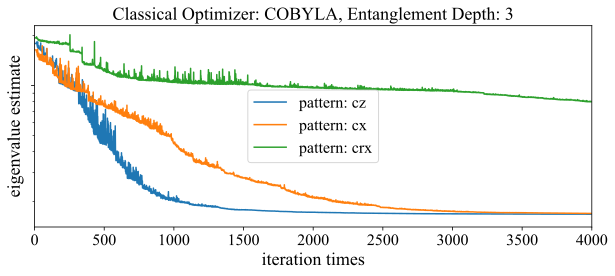

In [16]:
# Draw data from Excel and plot

# plt.figure(dpi=600)
pylab.rcParams['figure.figsize'] = (10,8)
fig = plt.figure(dpi=600)
ax = fig.add_subplot(2, 1, 2)

file = pd.read_excel(path_to_excel)
x = np.array([file['A'], file['B'], file['C']])
y = np.array([file['D'], file['E'], file['F']])

entanglement_gate = ['cz', 'cx', 'crx']
for i, var_form in enumerate(var_forms):
    pylab.plot(x[i], y[i], label='pattern: '+entanglement_gate[i])
pylab.yscale('log')

xlimit = 4000
pylab.xlim(0, xlimit)
# pylab.ylim(ref_value, 0.15)
# ylimit1 = 0.08; ylimit2 = 0.13
# pylab.ylim(ylimit1, ylimit2)

csfont = {'fontname':'Times New Roman'}
pylab.title('Classical Optimizer: COBYLA, Entanglement Depth: 3', **csfont, size=18)
pylab.xlabel('iteration times', **csfont, size=18)
pylab.ylabel('eigenvalue estimate', **csfont, size=18)

ticks_font = fm.FontProperties(
    family='Times New Roman', style='normal', size=16, weight='normal', stretch='normal')
for label in pylab.gca().get_xticklabels (): # get current axes
    label.set_fontproperties(ticks_font)
for label in pylab.gca().get_yticklabels ():
    label.set_fontproperties(ticks_font)
pylab.gca().yaxis.set_ticklabels([])

props = dict({'size': 16, 'family': 'Times New Roman', 'weight': 'normal', 'style': 'normal'})
pylab.legend(loc='best', prop=props)

pylab.show()

In [12]:
# Monitor via logging

import logging
logging.basicConfig(level=logging.INFO) # set the logging level to INFO
logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

# This will generate detailed log files